In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import copy

np.set_printoptions(precision=4)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('use_inf_as_na', True)

In [19]:
races = pd.read_csv('./f1db_csv/races.csv')
results = pd.read_csv('./f1db_csv/results.csv')
qualifying = pd.read_csv('./f1db_csv/qualifying.csv')
driver_standings = pd.read_csv('./f1db_csv/driver_standings.csv')
constructor_standings = pd.read_csv('./f1db_csv/constructor_standings.csv')
constructors = pd.read_csv('./f1db_csv/constructors.csv')
weather = pd.read_csv('./f1db_csv/weather.csv')
drivers = pd.read_csv('./f1db_csv/drivers.csv')
driver_history = pd.read_csv('./f1db_csv/driver_history.csv')
lap_times = pd.read_csv('./f1db_csv/lap_times.csv')

In [20]:
weather

,Unnamed: 0,raceId,year,round,weather,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,0,1,2009,1,Sunny with temperatures reaching up to 27 °C (...,1,0,0,0,0
1,1,2,2009,2,"Dry start, with heavy rain and thunderstorm/mo...",0,0,1,1,0
2,2,3,2009,3,Rain,0,0,0,1,0
3,3,4,2009,4,Sunny,1,0,0,0,0
4,4,5,2009,5,"Warm, Sunny",1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1030,1030,1043,2020,13,not found,0,0,0,0,0
1031,1031,1044,2020,14,not found,0,0,0,0,0
1032,1032,1045,2020,15,not found,0,0,0,0,0
1033,1033,1046,2020,16,not found,0,0,0,0,0


In [21]:
# Drop a few columns
# driver_standings.drop(['driver_points_after_race', 'driver_wins_after_race', 'driver_standings_pos_after_race'] ,axis = 1, inplace = True)
# constructor_standings.drop(['constructor_points_after_race', 'constructor_wins_after_race','constructor_standings_pos_after_race' ],axis = 1, inplace = True)

# Merge together to create final df for predictions
df1 = pd.merge(races, weather[["raceId", "weather_warm", "weather_cold", "weather_dry", "weather_wet", "weather_cloudy"]], on=['raceId'])
df2 = pd.merge(df1, results[["raceId", "driverId", "constructorId", "grid", "position", "points", "milliseconds", "laps", "fastestLapSpeed"]], on=['raceId'])
df2 = df2.rename({'position' : 'finishingPosition', 'points' : 'pointsGained'}, axis = 1)
df3 = pd.merge(df2, driver_standings[["raceId", "driverId", "points", "position", "wins"]], on=['raceId', 'driverId'])
df3 = df3.rename({'position' : 'driverStanding', 'points' : 'cumulativePoints', 'wins' : 'driver_wins'}, axis = 1)
df4 = pd.merge(df3, constructor_standings[["raceId", "constructorId", "points", "position", "wins"]], how='left', on=['raceId', 'constructorId']) #from 1958
df4 = df4.rename({'position' : 'constructorStanding', 'points' : 'constructorPoints', 'wins' : 'constructorWins', 'name' : 'raceName'}, axis = 1)
df5 = pd.merge(df4, constructors[["constructorId", "name"]], on = "constructorId")
df5 = df5.rename({'name' : 'constructorName'}, axis = 1)

# Match drivers in driver history table to their driver IDs
drivers["driverName"] = drivers["forename"].str.cat(drivers["surname"],sep = " ")
df6 = pd.merge(driver_history, drivers[["driverName", "driverId"]], on = "driverName")

final_df = pd.merge(df5, df6[["raceId", "driverId", "minQualifyingTime", "fastestLapTime"]], on=['raceId', 'driverId'])
final_df = final_df.drop(columns = ["round", "circuitId", "time", "url", "constructorId"])

# Rearrange the columns so identifying information is at the beginning
key = lambda x: (x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'finishingPosition')
final_df = final_df[sorted(final_df, key=key)]

In [22]:
# Get dummies for categorical variables
df_dum = pd.get_dummies(final_df, columns = ['constructorName'])
# Convert date to datetime
df_dum["date"] = pd.to_datetime(df_dum["date"])
df_dum = df_dum.sort_values("date", ascending = True)
df_dum

,raceId,date,year,raceName,driverId,finishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,pointsGained,milliseconds,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,minQualifyingTime,fastestLapTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Arrows,constructorName_BAR,constructorName_BMW Sauber,constructorName_Benetton,constructorName_Brawn,constructorName_Caterham,constructorName_Ferrari,constructorName_Footwork,constructorName_Force India,constructorName_Forti,constructorName_HRT,constructorName_Haas F1 Team,constructorName_Honda,constructorName_Jaguar,constructorName_Jordan,constructorName_Ligier,constructorName_Lotus,constructorName_Lotus F1,constructorName_MF1,constructorName_Manor Marussia,constructorName_Marussia,constructorName_McLaren,constructorName_Mercedes,constructorName_Minardi,constructorName_Prost,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Sauber,constructorName_Spyker,constructorName_Spyker MF1,constructorName_Stewart,constructorName_Super Aguri,constructorName_Toro Rosso,constructorName_Toyota,constructorName_Tyrrell,constructorName_Virgin,constructorName_Williams
6027,224,1996-03-10,1996,Australian Grand Prix,63,6,0,0,1,0,0,10,1.0,\N,57,\N,1.0,6,0,1.0,5.0,0.0,94.832,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4982,224,1996-03-10,1996,Australian Grand Prix,49,8,0,0,1,0,0,9,0.0,\N,57,\N,0.0,8,0,0.0,7.0,0.0,94.494,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1071,224,1996-03-10,1996,Australian Grand Prix,35,2,0,0,1,0,0,1,6.0,5608420,58,\N,6.0,2,0,16.0,1.0,1.0,92.371,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1070,224,1996-03-10,1996,Australian Grand Prix,71,1,0,0,1,0,0,2,10.0,5570400,58,\N,10.0,1,1,16.0,1.0,1.0,92.509,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6042,224,1996-03-10,1996,Australian Grand Prix,64,10,0,0,1,0,0,20,0.0,\N,56,\N,0.0,10,0,0.0,6.0,0.0,96.298,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,1039,2020-09-13,2020,Tuscan Grand Prix,154,12,1,0,0,0,0,15,0.0,8417096,59,229.532,0.0,21,0,1.0,9.0,0.0,77.069,82.263,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7443,1039,2020-09-13,2020,Tuscan Grand Prix,825,\N,1,0,0,0,0,20,0.0,\N,5,141.108,1.0,18,0,1.0,9.0,0.0,77.348,133.812,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6808,1039,2020-09-13,2020,Tuscan Grand Prix,8,9,1,0,0,0,0,13,2.0,8404830,59,232.640,2.0,16,0,4.0,8.0,0.0,76.854,81.164,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7502,1039,2020-09-13,2020,Tuscan Grand Prix,815,5,1,0,0,0,0,7,10.0,8390710,59,234.175,44.0,9,0,92.0,4.0,0.0,76.311,80.632,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
lap_times

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342
...,...,...,...,...,...,...
481854,1039,20,55,10,1:21.902,81902
481855,1039,20,56,10,1:21.643,81643
481856,1039,20,57,10,1:21.781,81781
481857,1039,20,58,10,1:21.454,81454


In [24]:
# Merge lap times data
total_lap_times = pd.merge(lap_times, races[["raceId", "year"]], on = "raceId")
total_lap_times = total_lap_times[["raceId", "driverId", "milliseconds"]]
total_lap_times = total_lap_times.groupby(['raceId', 'driverId']).sum()
total_lap_times["seconds"] = total_lap_times.milliseconds / 1000

# Merge in the seconds for each race
df_dum_merged = pd.merge(df_dum, total_lap_times, on = ["raceId", "driverId"])
df_dum_merged = df_dum_merged.drop(columns = ["milliseconds_x", "milliseconds_y"])

# Look only at 2020 data right now
df_2020 = df_dum_merged[df_dum_merged.year == 2020]

# Drop teams that didn't exist in 2020
for col in df_2020.columns:
    if 'constructorName' in col and df_2020[col].sum() < 1:
        df_2020.drop(col, axis = 1, inplace = True)

df_2020 = df_2020.sort_values(["date", "driverId"], ascending = True)

# Reformat the data so that it's taking info from the previous race
# Separate the data from the current race and the previous race
current_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "seconds", "weather_warm", "weather_cold", 
                      "weather_dry", "weather_wet", "weather_cloudy", "grid", "minQualifyingTime", 
                      "constructorName_Alfa Romeo", "constructorName_AlphaTauri", "constructorName_Ferrari", 
                      "constructorName_Haas F1 Team", "constructorName_McLaren", "constructorName_Mercedes", 
                      "constructorName_Racing Point", "constructorName_Red Bull", "constructorName_Renault", 
                      "constructorName_Williams"]]
past_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "pointsGained", 
                   "laps", "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints", "constructorStanding",
                   "constructorWins", "fastestLapTime"]]

# Change raceId for the past races so that info from the previous race gets matched to the current race for preds
past_df["raceId"] = past_df["raceId"] + 1

# Merge the two together for predictions
full_df = pd.merge(current_df, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps",
                                        "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", 
                                        "constructorPoints", "constructorStanding", "constructorWins", "fastestLapTime"]],
                   on = ["raceId", "driverId"], how = "inner")
full_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
1,1032,2020-07-12,2020,Styrian Grand Prix,8,5008.802,1,0,0,0,0,16,81.140,1,0,0,0,0,0,0,0,0,0,\N,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,69.031
2,1032,2020-07-12,2020,Styrian Grand Prix,20,101.037,1,0,0,0,0,10,79.545,0,0,1,0,0,0,0,0,0,0,10,1.0,71,226.524,1.0,10,0,19.0,3.0,0.0,68.623
3,1032,2020-07-12,2020,Styrian Grand Prix,154,5009.618,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,\N,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,70.228
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,1039,2020-09-13,2020,Tuscan Grand Prix,844,8403.405,1,0,0,0,0,5,76.270,0,0,1,0,0,0,0,0,0,0,\N,0.0,23,242.424,45.0,7,0,61.0,6.0,0.0,86.026
149,1039,2020-09-13,2020,Tuscan Grand Prix,846,8393.943,1,0,0,0,0,11,76.640,0,0,0,0,1,0,0,0,0,0,4,12.0,53,247.587,57.0,5,0,98.0,3.0,0.0,84.232
150,1039,2020-09-13,2020,Tuscan Grand Prix,847,8407.464,1,0,0,0,0,18,77.232,0,0,0,0,0,0,0,0,0,1,14,0.0,53,247.033,0.0,21,0,0.0,10.0,0.0,84.421
151,1039,2020-09-13,2020,Tuscan Grand Prix,848,8383.124,1,0,0,0,0,4,75.914,0,0,0,0,0,0,0,1,0,0,15,0.0,53,245.564,48.0,6,0,158.0,2.0,1.0,84.926


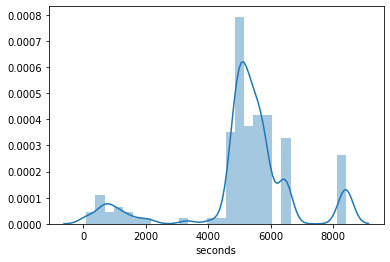

In [25]:
sns.distplot(full_df.seconds)

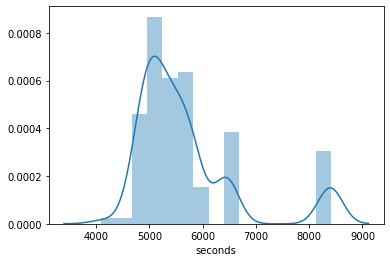

In [26]:
# Cut off the people who finished under 4000 seconds
shortened_df = full_df[full_df.seconds > 4000]
sns.distplot(shortened_df.seconds)

In [27]:
# Delete rows where there are nans
shortened_df = shortened_df.replace({r"\N": None})
shortened_df = shortened_df.dropna()

min_df = shortened_df.groupby("raceId", as_index = False)
min_lap_time = min_df.fastestLapTime.min()
temp1 = pd.merge(shortened_df, min_lap_time, on = "raceId")  
temp1["fastestLapRatio"] = temp1["fastestLapTime_x"] / temp1["fastestLapTime_y"]
temp1 = temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
min_quali_time = min_df.minQualifyingTime.min()
temp2 = pd.merge(temp1, min_quali_time, on = "raceId")
temp2["minQualiRatio"] = temp2["minQualifyingTime_x"] / temp2["minQualifyingTime_y"]
temp2 = temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
temp2

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapRatio,minQualiRatio
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,1.003512,1.000000
1,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,1.012301,1.048596
2,1032,2020-07-12,2020,Styrian Grand Prix,822,4984.402,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,1,25.0,71,229.758,25.0,1,1,37.0,1.0,1.0,1.002697,1.010691
3,1032,2020-07-12,2020,Styrian Grand Prix,826,5000.934,1,0,0,0,0,13,0,1,0,0,0,0,0,0,0,0,12,0.0,69,224.847,0.0,12,0,6.0,5.0,0.0,1.024602,1.024311
4,1032,2020-07-12,2020,Styrian Grand Prix,832,4989.726,1,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,5,10.0,71,228.687,10.0,5,0,26.0,2.0,0.0,1.007395,1.009830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1039,2020-09-13,2020,Tuscan Grand Prix,826,8396.816,1,0,0,0,0,12,0,1,0,0,0,0,0,0,0,0,9,2.0,53,246.863,4.0,15,0,47.0,7.0,1.0,1.020944,1.022756
113,1039,2020-09-13,2020,Tuscan Grand Prix,840,5492.748,1,0,0,0,0,6,0,0,0,0,0,0,1,0,0,0,3,15.0,53,248.576,57.0,4,0,82.0,4.0,0.0,1.013910,1.014998
114,1039,2020-09-13,2020,Tuscan Grand Prix,846,8393.943,1,0,0,0,0,11,0,0,0,0,1,0,0,0,0,0,4,12.0,53,247.587,57.0,5,0,98.0,3.0,0.0,1.017959,1.019908
115,1039,2020-09-13,2020,Tuscan Grand Prix,847,8407.464,1,0,0,0,0,18,0,0,0,0,0,0,0,0,0,1,14,0.0,53,247.033,0.0,21,0,0.0,10.0,0.0,1.020243,1.027787


In [28]:
# Train on this above data
training_df = shortened_df[shortened_df.raceId != 1040]
x = training_df.iloc[:, 6:]
x = x.drop(columns = "laps")
x["fastestLapSpeed"] = pd.to_numeric(x["fastestLapSpeed"])
x["finishingPosition"] = pd.to_numeric(x["finishingPosition"])
y = training_df.iloc[:, 5]

In [29]:
# Linear regression on this data to predict results for the 2020 Spanish Grand Prix
model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9)
model.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [30]:
training_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
6,1032,2020-07-12,2020,Styrian Grand Prix,822,4984.402,1,0,0,0,0,4,78.657,0,0,0,0,0,1,0,0,0,0,1,25.0,71,229.758,25.0,1,1,37.0,1.0,1.0,67.657
8,1032,2020-07-12,2020,Styrian Grand Prix,826,5000.934,1,0,0,0,0,13,79.717,0,1,0,0,0,0,0,0,0,0,12,0.0,69,224.847,0.0,12,0,6.0,5.0,0.0,69.135
10,1032,2020-07-12,2020,Styrian Grand Prix,832,4989.726,1,0,0,0,0,3,78.590,0,0,0,0,1,0,0,0,0,0,5,10.0,71,228.687,10.0,5,0,26.0,2.0,0.0,67.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1039,2020-09-13,2020,Tuscan Grand Prix,826,8396.816,1,0,0,0,0,12,76.854,0,1,0,0,0,0,0,0,0,0,9,2.0,53,246.863,4.0,15,0,47.0,7.0,1.0,84.479
146,1039,2020-09-13,2020,Tuscan Grand Prix,840,5492.748,1,0,0,0,0,6,76.271,0,0,0,0,0,0,1,0,0,0,3,15.0,53,248.576,57.0,4,0,82.0,4.0,0.0,83.897
149,1039,2020-09-13,2020,Tuscan Grand Prix,846,8393.943,1,0,0,0,0,11,76.640,0,0,0,0,1,0,0,0,0,0,4,12.0,53,247.587,57.0,5,0,98.0,3.0,0.0,84.232
150,1039,2020-09-13,2020,Tuscan Grand Prix,847,8407.464,1,0,0,0,0,18,77.232,0,0,0,0,0,0,0,0,0,1,14,0.0,53,247.033,0.0,21,0,0.0,10.0,0.0,84.421


In [31]:
qualifying

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
8549,8573,1040,154,210,8,16,1:34.592,\N,\N
8550,8574,1040,841,51,99,17,1:34.594,\N,\N
8551,8575,1040,825,210,20,18,1:34.681,\N,\N
8552,8576,1040,849,3,6,19,1:35.066,\N,\N


In [32]:
# Create df for Russian Grand Prix
# Take final_df from all the merging done before
training_df1 = final_df[final_df.raceId == 1039]
# Get the minimum qualifying time from each driver for the Spanish Grand Prix
sp_quali_df = qualifying[qualifying.raceId == 1040]
sp_quali_df["minQualifyingTime"] = sp_quali_df[["q1", "q2", "q3"]].min(skipna = True, axis = 1)
sp_quali_df = sp_quali_df.drop(columns = ["q1", "q2", "q3"])
# Convert to seconds
for i in range(len(sp_quali_df['minQualifyingTime'])):
    if  sp_quali_df['minQualifyingTime'].iloc[i] != 0:
        sp_quali_df['minQualifyingTime'].iloc[i] = float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[1]) + (60 * float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[0]))
        i += 1
    else:
        sp_quali_df['minQualifyingTime'].iloc[i] = None
        i += 1
# Match the constructorId to the constructorName
sp_quali_df1 = pd.merge(sp_quali_df, constructors[["constructorId", "name"]], on = "constructorId")
sp_quali_df1 = sp_quali_df1.rename({'name' : 'constructorName', 'position': 'grid'}, axis = 1)
sp_quali_df1 = pd.get_dummies(sp_quali_df1, columns = ['constructorName'])
sp_quali_df2 = pd.merge(sp_quali_df1, weather, on = "raceId")

# Rearrange this df so it's in the same format 
sp_quali_df2 = sp_quali_df2[["raceId", "driverId", "weather_warm", "weather_cold", "weather_dry", "weather_wet",
                             "weather_cloudy", "grid", "minQualifyingTime", "constructorName_Alfa Romeo", 
                             "constructorName_AlphaTauri", "constructorName_Ferrari", "constructorName_Haas F1 Team",
                             "constructorName_McLaren", "constructorName_Mercedes", "constructorName_Racing Point",
                             "constructorName_Red Bull", "constructorName_Renault", "constructorName_Williams"]]
x_test1 = pd.merge(sp_quali_df2, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps", "fastestLapSpeed",
                                     "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints",
                                     "constructorStanding", "constructorWins", "fastestLapTime"]], on = ["raceId", "driverId"], how = "left")
x_test1 = x_test1.replace({r"\N": None})
# x_test1 = x_test1.dropna()
x_test = x_test1.iloc[:, 2:]
x_test["fastestLapSpeed"] = pd.to_numeric(x_test["fastestLapSpeed"])
x_test["finishingPosition"] = pd.to_numeric(x_test["finishingPosition"])
x_test = x_test.drop(columns = "laps")

In [33]:
x_test1

,raceId,driverId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1040,1,1,0,0,0,0,1,91.304,0,0,0,0,0,1,0,0,0,0,1,26.0,59.0,239.518,190.0,1.0,6.0,325.0,1.0,7.0,78.833
1,1040,822,1,0,0,0,0,3,91.956,0,0,0,0,0,1,0,0,0,0,2,18.0,59.0,237.712,135.0,2.0,1.0,325.0,1.0,7.0,79.432
2,1040,830,1,0,0,0,0,2,91.867,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1040,848,1,0,0,0,0,10,93.008,0,0,0,0,0,0,0,1,0,0,3,15.0,59.0,235.909,63.0,5.0,0.0,173.0,2.0,1.0,80.039
4,1040,815,1,0,0,0,0,4,92.317,0,0,0,0,0,0,1,0,0,0,5,10.0,59.0,234.175,44.0,9.0,0.0,92.0,4.0,0.0,80.632
5,1040,840,1,0,0,0,0,13,93.364,0,0,0,0,0,0,1,0,0,0,None,0.0,42.0,230.077,57.0,6.0,0.0,92.0,4.0,0.0,82.068
6,1040,817,1,0,0,0,0,5,92.218,0,0,0,0,0,0,0,0,1,0,4,12.0,59.0,234.774,53.0,7.0,0.0,83.0,5.0,0.0,80.426
7,1040,839,1,0,0,0,0,7,92.624,0,0,0,0,0,0,0,0,1,0,None,0.0,7.0,143.270,30.0,12.0,0.0,83.0,5.0,0.0,131.793
8,1040,832,1,0,0,0,0,6,92.550,0,0,0,0,1,0,0,0,0,0,None,0.0,5.0,140.802,41.0,11.0,0.0,106.0,3.0,0.0,134.103
9,1040,846,1,0,0,0,0,8,92.847,0,0,0,0,1,0,0,0,0,0,6,8.0,59.0,232.542,65.0,4.0,0.0,106.0,3.0,0.0,81.198


In [34]:
x_test

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1,0,0,0,0,1,91.304,0,0,0,0,0,1,0,0,0,0,1.0,26.0,239.518,190.0,1.0,6.0,325.0,1.0,7.0,78.833
1,1,0,0,0,0,3,91.956,0,0,0,0,0,1,0,0,0,0,2.0,18.0,237.712,135.0,2.0,1.0,325.0,1.0,7.0,79.432
2,1,0,0,0,0,2,91.867,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,0,10,93.008,0,0,0,0,0,0,0,1,0,0,3.0,15.0,235.909,63.0,5.0,0.0,173.0,2.0,1.0,80.039
4,1,0,0,0,0,4,92.317,0,0,0,0,0,0,1,0,0,0,5.0,10.0,234.175,44.0,9.0,0.0,92.0,4.0,0.0,80.632
5,1,0,0,0,0,13,93.364,0,0,0,0,0,0,1,0,0,0,NaN,0.0,230.077,57.0,6.0,0.0,92.0,4.0,0.0,82.068
6,1,0,0,0,0,5,92.218,0,0,0,0,0,0,0,0,1,0,4.0,12.0,234.774,53.0,7.0,0.0,83.0,5.0,0.0,80.426
7,1,0,0,0,0,7,92.624,0,0,0,0,0,0,0,0,1,0,NaN,0.0,143.270,30.0,12.0,0.0,83.0,5.0,0.0,131.793
8,1,0,0,0,0,6,92.550,0,0,0,0,1,0,0,0,0,0,NaN,0.0,140.802,41.0,11.0,0.0,106.0,3.0,0.0,134.103
9,1,0,0,0,0,8,92.847,0,0,0,0,1,0,0,0,0,0,6.0,8.0,232.542,65.0,4.0,0.0,106.0,3.0,0.0,81.198


In [35]:
# Save x_test to a csv to manipulate for the feature engineered table
x_test1.to_csv("./predictions/ru_2020_raw_table")

In [36]:
# Predict on x_test
sp_preds = model.predict(x_test)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
sp_preds_df
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId") 
full_sp_df["avg_pred_lap"] = full_sp_df.Predictions / full_sp_df.laps
full_sp_df = full_sp_df.sort_values("avg_pred_lap")
full_sp_df = full_sp_df.reset_index(drop=True)
full_sp_df["Predicted Position"] = full_sp_df.index + 1
full_sp_df

,Predictions,raceId,driverId,laps,driverName,avg_pred_lap,Predicted Position
0,5436.154297,1039,154,53,Romain Grosjean,102.568949,1
1,5461.523438,1039,842,53,Pierre Gasly,103.047612,2
2,5471.117676,1039,8,53,Kimi Räikkönen,103.228635,3
3,5487.001465,1039,847,53,George Russell,103.528330,4
4,5500.601074,1039,826,53,Daniil Kvyat,103.784926,5
5,5517.231445,1039,1,53,Lewis Hamilton,104.098707,6
6,5527.689453,1039,817,53,Daniel Ricciardo,104.296027,7
7,5530.725098,1039,839,53,Esteban Ocon,104.353304,8
8,5536.183594,1039,840,53,Lance Stroll,104.456294,9
9,5544.738770,1039,832,53,Carlos Sainz,104.617713,10


In [40]:
# Save predictions into a CSV
be_2020_raw_predictions = full_sp_df[["Predicted Position", "driverName"]]
be_2020_raw_predictions = be_2020_raw_predictions.rename({"driverName" : "Driver Name"}, axis = 1)
be_2020_raw_predictions.to_csv("./predictions/it_2020_raw_predictions.csv")

In [26]:
# What if it's raining?
x_test2 = copy.deepcopy(x_test)
x_test2["weather_wet"] = 1
x_test2

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,0,0,0,1,1,1,101.252,0,0,0,0,0,1,0,0,0,0,1.0,25.0,209.942,132.0,1,4,221.0,1.0,5.0,79.822
1,0,0,0,1,1,2,101.763,0,0,0,0,0,1,0,0,0,0,3.0,16.0,214.343,89.0,3,1,221.0,1.0,5.0,78.183
2,0,0,0,1,1,3,101.778,0,0,0,0,0,0,0,1,0,0,2.0,18.0,205.677,95.0,2,1,135.0,2.0,1.0,81.477
3,0,0,0,1,1,5,102.193,0,0,0,0,0,0,0,1,0,0,8.0,4.0,203.883,40.0,6,0,135.0,2.0,1.0,82.194
4,0,0,0,1,1,4,102.061,0,0,0,0,0,0,0,0,1,0,11.0,0.0,203.215,20.0,10,0,36.0,6.0,0.0,82.464
5,0,0,0,1,1,6,102.396,0,0,0,0,0,0,0,0,1,0,13.0,0.0,203.933,16.0,12,0,36.0,6.0,0.0,82.174
6,0,0,0,1,1,7,102.438,0,0,0,0,1,0,0,0,0,0,6.0,8.0,204.938,23.0,9,0,62.0,4.0,0.0,81.771
7,0,0,0,1,1,10,102.657,0,0,0,0,1,0,0,0,0,0,10.0,1.0,203.393,39.0,7,0,62.0,4.0,0.0,82.392
8,0,0,0,1,1,8,102.532,0,0,0,0,0,0,1,0,0,0,5.0,10.0,203.090,32.0,8,0,63.0,3.0,0.0,82.515
9,0,0,0,1,1,9,102.491,0,0,0,0,0,0,1,0,0,0,4.0,12.0,204.306,40.0,5,0,63.0,3.0,0.0,82.024


In [27]:
# Predict on this new one
sp_preds = model.predict(x_test2)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
sp_preds_df
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_sp_df["driverName"])):
    if full_sp_df["driverName"][i] == "Sergio Pérez":
        full_sp_df["laps"][i] = 52.0   
full_sp_df["avg_pred_lap"] = full_sp_df.Predictions / full_sp_df.laps
full_sp_df = full_sp_df.sort_values("avg_pred_lap")
full_sp_df = full_sp_df.reset_index(drop=True)
full_sp_df["Predicted Position"] = full_sp_df.index + 1
full_sp_df

,Predictions,raceId,driverId,laps,driverName,avg_pred_lap,Predicted Position
0,5781.558594,1037,1,66,Lewis Hamilton,87.599373,1
1,5792.836914,1037,830,66,Max Verstappen,87.770256,2
2,5796.507324,1037,822,66,Valtteri Bottas,87.825869,3
3,5782.080566,1037,817,65,Daniel Ricciardo,88.955086,4
4,5782.606934,1037,839,65,Esteban Ocon,88.963184,5
5,5807.911621,1037,840,65,Lance Stroll,89.352486,6
6,5811.542969,1037,848,65,Alexander Albon,89.408353,7
7,5814.344727,1037,832,65,Carlos Sainz,89.451457,8
8,5815.927246,1037,825,65,Kevin Magnussen,89.475804,9
9,5818.729004,1037,846,65,Lando Norris,89.518908,10
